In [217]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple


# Parámetros del entorno
MAX_STATE = 10           # Escala de 0 a 10 para C1 y C2
LAMBDA_ARRIVAL_C1 = 4       # Parámetro de la distribución de Poisson para llegadas
LAMBDA_ARRIVAL_C2 = 1       # Parámetro de la distribución de Poisson para llegadas

# Parámetros de Q-Learning
ALPHA = 0.1              # Tasa de aprendizaje
GAMMA = 0.9             # Factor de descuento
EPSILON = 1.0            # Tasa de exploración inicial
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
NUM_EPISODES = 10001
STEPS_PER_EPISODE = 50

In [218]:
# Definición de las tres acciones:
# Cada acción define en cuánto se reduce la congestión actual en cada carril.
actions = {
    0: {'C1_reduction': 8, 'C2_reduction': 4},  # Prioriza C1
    1: {'C1_reduction': 4, 'C2_reduction': 8},  # Prioriza C2
    2: {'C1_reduction': 5, 'C2_reduction': 5},  # Equilibrado
}

# Función de recompensa dinámica según el nivel de congestión
def compute_reward(c1, c2):
    # Si C1 está congestionado (mayor a 7) y es el que tiene mayor o igual congestión
    if c1 > 7 and c1 >= c2:
        return -(2 * c1 + c2)
    # Si C2 está congestionado (mayor a 7) y es el que tiene mayor congestión
    elif c2 > 7 and c2 > c1:
        return -(c1 + 2 * c2)
    # Si ambos carriles tienes igual congestión alta/baja
    else:
        return -(c1 + c2)
    
    
#def compute_reward(c1, c2):
#    return -(c1 + c2)

# Definición del entorno
class TrafficEnv:
    def __init__(self, c1_lambda, c2_lambda):
        self.reset()
        self.c1_lambda = c1_lambda
        self.c2_lambda = c2_lambda

    def reset(self):
        # Estado inicial: congestion en C1 y C2 (valores bajos)
        self.c1 = random.randint(0, 3)
        self.c2 = random.randint(0, 3)
        return (self.c1, self.c2)

    def step(self, action):
        # Aplicar efecto de la acción: reducir congestión sin bajar de cero
        reduction = actions[action]
        self.c1 = max(self.c1 - reduction['C1_reduction'], 0)
        self.c2 = max(self.c2 - reduction['C2_reduction'], 0)
        
        # Llegadas de nuevos vehículos según distribución de Poisson
        arrival_c1 = np.random.poisson(self.c1_lambda)
        arrival_c2 = np.random.poisson(self.c2_lambda)
        self.c1 = min(self.c1 + arrival_c1, MAX_STATE)
        self.c2 = min(self.c2 + arrival_c2, MAX_STATE)
        
        # Calcular la recompensa en función del estado actualizado
        reward = compute_reward(self.c1, self.c2)
        next_state = (self.c1, self.c2)
        done = False  # En este ejemplo, cada episodio tiene un número fijo de pasos
        return next_state, reward, done

## Random approach (baseline)

Episode 0: Total reward = -6.24
Episode 500: Total reward = -6.28
Episode 1000: Total reward = -6.78
Episode 1500: Total reward = -9.16
Episode 2000: Total reward = -8.3
Episode 2500: Total reward = -5.26
Episode 3000: Total reward = -8.16
Episode 3500: Total reward = -5.82
Episode 4000: Total reward = -6.32
Episode 4500: Total reward = -7.86
Episode 5000: Total reward = -7.32
Episode 5500: Total reward = -5.26
Episode 6000: Total reward = -7.44
Episode 6500: Total reward = -6.28
Episode 7000: Total reward = -5.98
Episode 7500: Total reward = -7.02
Episode 8000: Total reward = -7.04
Episode 8500: Total reward = -7.32
Episode 9000: Total reward = -5.88
Episode 9500: Total reward = -6.92
Episode 10000: Total reward = -7.52


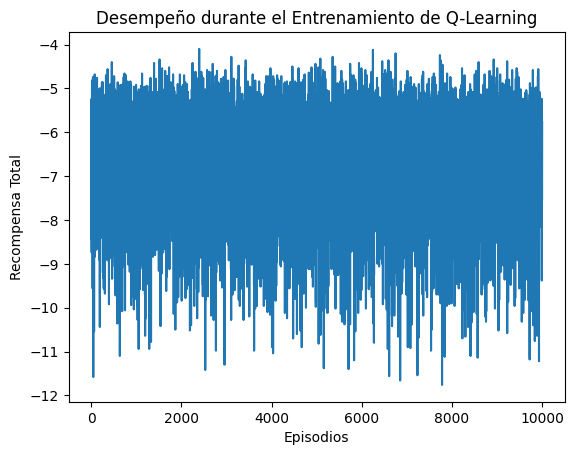

In [219]:
# Baseline always choose the same action:

# Inicialización de la tabla Q
q_table = np.zeros((MAX_STATE + 1, MAX_STATE + 1, len(actions)))


# Bucle de entrenamiento
env = TrafficEnv(LAMBDA_ARRIVAL_C1, LAMBDA_ARRIVAL_C2)
rewards_per_episode = []
epsilon = EPSILON

episode_changes = [3000, 6000]

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = random.randint(0, len(actions)-1) 
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        state = next_state
        total_reward += reward
        
        # Actualización Q-Learning (Ecuación de Bellman)
        #best_next = np.max(q_table[next_c1, next_c2, :])
        #q_table[c1, c2, action] += ALPHA * (reward + GAMMA * best_next - q_table[c1, c2, action])
        
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")
        
    if episode in episode_changes:
        if episode == 3000:
            env.c1_lambda = 1
            env.c2_lambda = 4
        elif episode == 6000:
            env.c1_lambda = 4
            env.c2_lambda = 1

# Graficar el desempeño del agente durante el entrenamiento
plt.plot(rewards_per_episode)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Total")
plt.title("Desempeño durante el Entrenamiento de Q-Learning")
plt.show()


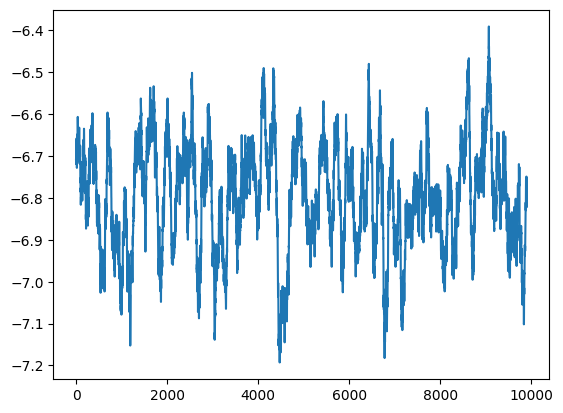

In [220]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(rewards_per_episode, 100))

## Traditional Q-learning approach (baseline)

In [221]:
# Inicialización de la tabla Q|
q_table = np.zeros((MAX_STATE + 1, MAX_STATE + 1, len(actions)))

def choose_action(state, epsilon):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randint(0, len(actions)-1)  # Exploración
    else:
        return np.argmax(q_table[c1, c2, :])      # Explotación

# Bucle de entrenamiento
env = TrafficEnv(LAMBDA_ARRIVAL_C1, LAMBDA_ARRIVAL_C2)
rewards_per_episode = []
epsilon = EPSILON

episode_changes = [3000, 6000]

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = choose_action(state, epsilon)
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        state = next_state
        total_reward += reward
        
        # Actualización Q-Learning (Ecuación de Bellman)
        best_next = np.max(q_table[next_c1, next_c2, :])
        q_table[c1, c2, action] += ALPHA * (reward + GAMMA * best_next - q_table[c1, c2, action])
                
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")
        
    if episode in episode_changes:
        if episode == 3000:
            env.c1_lambda = 1
            env.c2_lambda = 4
        elif episode == 6000:
            env.c1_lambda = 4
            env.c2_lambda = 1
        
np.mean(rewards_per_episode), np.std(rewards_per_episode), np.max(rewards_per_episode), np.min(rewards_per_episode)

Episode 0: Total reward = -6.34
Episode 500: Total reward = -5.12
Episode 1000: Total reward = -5.4
Episode 1500: Total reward = -5.08
Episode 2000: Total reward = -5.48
Episode 2500: Total reward = -4.7
Episode 3000: Total reward = -5.12
Episode 3500: Total reward = -4.62
Episode 4000: Total reward = -5.7
Episode 4500: Total reward = -5.48
Episode 5000: Total reward = -5.46
Episode 5500: Total reward = -5.4
Episode 6000: Total reward = -5.58
Episode 6500: Total reward = -5.34
Episode 7000: Total reward = -5.1
Episode 7500: Total reward = -5.34
Episode 8000: Total reward = -5.46
Episode 8500: Total reward = -5.98
Episode 9000: Total reward = -5.7
Episode 9500: Total reward = -6.06
Episode 10000: Total reward = -4.6


(-5.605659434056594, 0.6411563143737209, -3.82, -10.14)

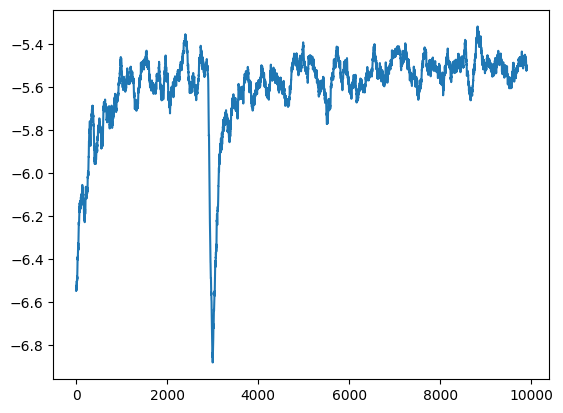

In [222]:
plt.plot(moving_average(rewards_per_episode, 100))

## Adaptive Agent

In [223]:
class PageHinkley:
    def __init__(self, delta=0.01, threshold=300.0):
        """
        Parámetros:
          - delta: un pequeño valor (bias) que evita detectar cambios por fluctuaciones menores.
          - threshold: umbral que, al ser superado, indica que se ha detectado un cambio.
        """
        self.delta = delta
        self.threshold = threshold
        self.reset()

    def reset(self):
        """Reinicia los acumulados y contadores del test."""
        self.mean = 0.0
        self.cumulative_sum = 0.0
        self.min_cumulative_sum = 0.0
        self.n = 0

    def update(self, x):
        """
        Actualiza el PH-Test con el valor x (en este caso, la recompensa acumulada del episodio)
        y retorna True si se detecta un cambio.
        """
        self.n += 1
        # Actualización incremental de la media
        self.mean = self.mean + (x - self.mean) / self.n
        # Se acumula la diferencia entre el valor actual, la media y el delta
        self.cumulative_sum += (self.mean - x - self.delta)
        # Se guarda el mínimo acumulado
        self.min_cumulative_sum = min(self.min_cumulative_sum, self.cumulative_sum)
        # Si la diferencia acumulada (desde el mínimo) supera el umbral, se detecta un cambio
        
        if (self.cumulative_sum - self.min_cumulative_sum) > self.threshold:
            return True
        else:
            return False


In [224]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje base
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003,
        alpha_max: float = 0.99,  # Tasa de aprendizaje máxima en caso de gran error
        td_threshold: float = 0.1,  # Umbral para activar adaptación
    ):
        # Parámetros de Q-learning
        self.alpha = alpha              # Tasa base
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.alpha_max = alpha_max
        self.td_threshold = td_threshold
        self.effective_alpha = alpha
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = np.zeros((len(self.actions), self.n_rows, self.n_cols))
        
        # Contadores
        self.steps = 0
        
        # Aux
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}      
    
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        action = np.argmax(self.q_knowledge[:, state[0], state[1]])
        action = self.map_ix_action[action]
        q_value = np.max(self.q_knowledge[:, state[0], state[1]])
        return action, q_value
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> float:
        """
        Actualiza la Q-table usando una tasa de aprendizaje adaptativa que 
        fusiona el conocimiento previo con la nueva información.
        """
        action = self.map_action_ix[action]
        current_q = self.q_knowledge[action][current_state]
        # Obtener la mejor acción en el siguiente estado
        _, next_max_q = self.get_best_action(next_state)
        
        # Calcular el TD error
        td_error = reward + self.gamma * next_max_q - current_q
        
        # Función sigmoide para ajustar la tasa de aprendizaje:
        activation = 1.0 / (1.0 + np.exp(-(abs(td_error) - self.td_threshold)))
        effective_alpha = self.alpha + (self.alpha_max - self.alpha) * activation
        
        # Actualizar la Q-table de forma "fuzzy":
        self.effective_alpha = effective_alpha
        new_q = current_q + self.effective_alpha * td_error            
        
        self.q_knowledge[action][current_state] = new_q
        
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random.random() < epsilon:
            return random.choice(self.actions)
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step: int) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate * step)
    
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial sin borrar la Q-table (se conserva el conocimiento)"""
        self.current_state = self.initial_state
        self.steps = 0
        
    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"


In [225]:
# Inicialización del entorno y parámetros
N_ROWS = MAX_STATE + 1
N_COLS = MAX_STATE + 1


EXPLOTATION = 0.2


# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=[0,1,2],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=.002, # más grande => más errático
    alpha=0.1,
    alpha_max=0.99,
    td_threshold=5, # más pequeño => más sensible
    min_epsilon=EPSILON_MIN,
)

# alpha y epsilon deben ser directamente proporcionales

# Inicialización del Page-Hinkley Test
ph_test = PageHinkley(delta=0.5, threshold=7)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []

change_detection = []

alpha_evol = []
episode = 0
e = 0     # Contador para la función de decaimiento de epsilon


q_learning_acc = 0.0


outlier_reward = None

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, c2_lambda=LAMBDA_ARRIVAL_C2)
rewards_per_episode = []

episode_changes = [3000, 6000]

c1_h = []
c2_h = []

# Bucle de entrenamiento
for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        # Selecciona la acción usando epsilon adaptativo
        adaptive_epsilon = agent.epsilon_decay(step=e)
        action = agent.choose_action(adaptive_epsilon)
        next_state, reward, done = env.step(action)
        c1, c2 = state
        c1_h.append(c1)
        c2_h.append(c2)
        next_c1, next_c2 = next_state
        # Actualiza el estado actual del agente
        agent.current_state = next_state
        state = next_state
        # Acumula la recompensa del episodio
        total_reward += reward
        
        # Actualiza la Q-table usando la función de actualización
        new_q = agent.update_q_value(
            current_state=(c1, c2),
            action=action,
            reward=reward,
            next_state=(next_c1, next_c2)
        )

        # Realiza el movimiento y actualiza la Q-table
        q_learning_acc += new_q

        # Actualiza métricas (por ejemplo, para visualización)
        exploration_curve.append([adaptive_epsilon, new_q])
        alpha_evol.append(agent.effective_alpha)
        
        #print(f"({episode},{step}) --- alpha", agent.effective_alpha, "--- epsilon", adaptive_epsilon)
        
    # Finaliza el episodio si se alcanza un objetivo o se excede un límite de pasos
    e += 1

    episode += 1
            
    # Registra la recompensa media del episodio (puedes ajustar la métrica que prefieras)
    
    total_reward /= STEPS_PER_EPISODE
    if ph_test.update(total_reward):
        outlier_reward = total_reward
        e *= 0.5
        print(f"Cambio detectado en episodio {episode} con recompensa {total_reward}", e)
        change_detection.append(episode)
        ph_test.reset()
            
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward}") 
        
    if episode in episode_changes:
        if episode == 3000:
            env.c1_lambda = 1
            env.c2_lambda = 4
        elif episode == 6000:
            env.c1_lambda = 4
            env.c2_lambda = 1
        
    rewards_per_episode.append(total_reward)

Episode 500: Total reward = -7.08
Episode 1000: Total reward = -5.5
Episode 1500: Total reward = -6.14
Episode 2000: Total reward = -6.84
Episode 2500: Total reward = -5.38
Episode 3000: Total reward = -7.3
Cambio detectado en episodio 3162 con recompensa -8.46 1581.0
Episode 3500: Total reward = -5.18
Episode 4000: Total reward = -7.04
Episode 4500: Total reward = -4.6
Episode 5000: Total reward = -6.36
Episode 5500: Total reward = -5.18
Episode 6000: Total reward = -7.18
Episode 6500: Total reward = -6.46
Episode 7000: Total reward = -5.86
Episode 7500: Total reward = -5.22
Episode 8000: Total reward = -5.48
Episode 8500: Total reward = -5.98
Episode 9000: Total reward = -5.14
Episode 9500: Total reward = -5.18
Episode 10000: Total reward = -5.24


In [226]:
np.mean(rewards_per_episode), np.std(rewards_per_episode), np.max(rewards_per_episode), np.min(rewards_per_episode)

(-5.9644615538446155, 0.7759309799577405, -3.78, -10.94)

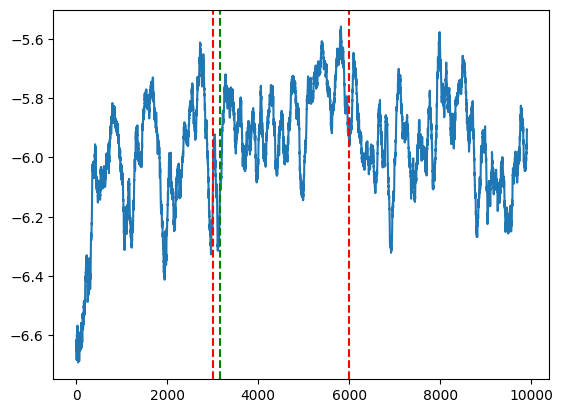

In [227]:
plt.plot(moving_average(rewards_per_episode, 100))
for v in episode_changes:
    plt.axvline(x=v, color='r', linestyle='--')
for c in change_detection:
    plt.axvline(x=c, color='g', linestyle='--')

(0.0, 100.0)

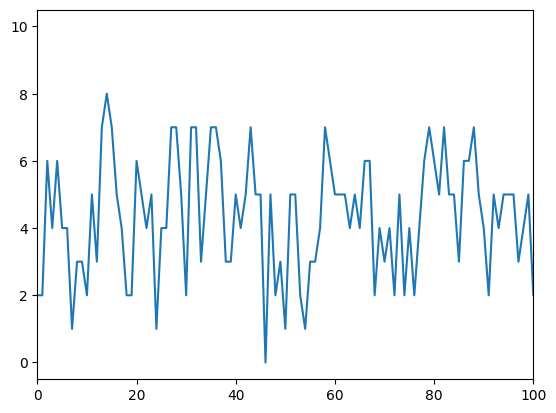

In [228]:
plt.plot(c1_h, label="C1")
plt.xlim(0, 100)

(0.0, 100.0)

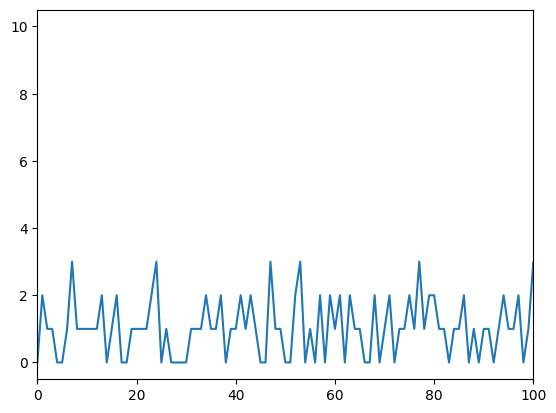

In [229]:
plt.plot(c2_h, label="C2")
plt.xlim(0, 100)

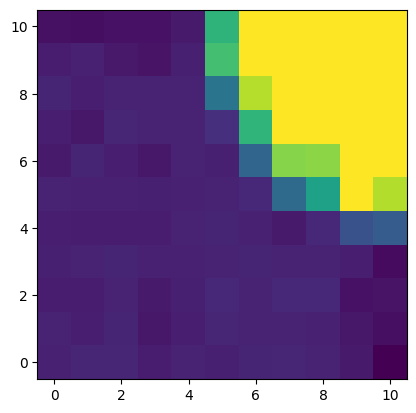

In [230]:
plt.imshow(np.max(q_table, axis=2), origin='lower')